# Data Exploration

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kstest

In [2]:
import os
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

USER = os.environ['USER']

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
cluster = PBSCluster(
    cores=1,
    memory='25GB', #25
    processes=1,
    queue='casper',
    local_directory=f'/glade/scratch/{USER}/dask-workers',
    log_directory=f'/glade/scratch/{USER}/dask-workers',
    resource_spec='select=1:ncpus=1:mem=25GB',
    project='P93300070',
    walltime='02:00:00',
    interface='ib0')

client = Client(cluster)
cluster.scale(20) # use when running climatology calculations
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:42311,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Daily Data

In [55]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/daily/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.ecosys.nday1.'
daily_data = xr.open_mfdataset(base+'*.nc', concat_dim="time", parallel = True, chunks = {'time':365},
                              data_vars='minimal', compat='override', 
                              coords='minimal')
daily_data

<xarray.Dataset>
Dimensions:                     (time: 10950, nlat: 384, nlon: 320)
Coordinates:
  * time                        (time) object 0020-01-01 00:00:00 ... 0049-12...
    ULONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables: (12/14)
    totChl                      (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_sat_nocld            (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_sat_nocld_wgt        (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_isccp_wgt            (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_isccp                (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis                (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    ...                          ...
    totChl_sat_nocld_wgt_swath  (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis_swath          (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis_wgt_swath      (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_modis             (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_isccp             (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_wgt               (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>

# Climatologies

What is the distribution of variables in space?

In [4]:
climatologies = xr.open_mfdataset('../data/*_mean.nc')

## Chlorophyll

In [9]:
climatologies.drop_vars(['ULONG','ULAT','TLONG','TLAT','lat','lon'])\
                        [['totChl','baseline_chlor','modis_chlor','isccp_chlor']].to_dataframe().describe()

,totChl,baseline_chlor,modis_chlor,isccp_chlor
count,86096.000000,86096.000000,86096.000000,86096.000000
mean,0.224379,0.347157,0.336178,0.337900
std,0.247897,0.441396,0.429944,0.439802
min,0.008153,0.009701,0.009285,0.008932
25%,0.087303,0.088748,0.088318,0.088105
50%,0.136192,0.153681,0.154561,0.154307
75%,0.254444,0.406368,0.403991,0.405629
max,19.938999,20.193005,19.525461,19.106428


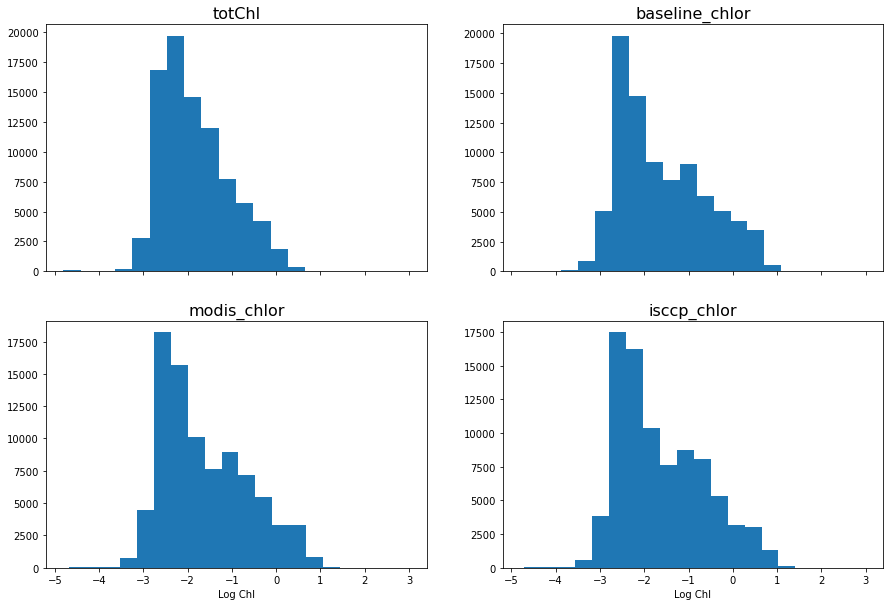

In [54]:
fig, ax = plt.subplots(2,2, figsize = (15,10), sharex = True)

ax = ax.flatten()

# Make the first histogram
ax[0].hist(np.log(climatologies.totChl).to_numpy().flatten(), bins = 20)
ax[0].set_title('totChl', fontsize = 16);

ax[1].hist(np.log(climatologies.baseline_chlor).to_numpy().flatten(), bins = 20)
ax[1].set_title('baseline_chlor', fontsize = 16);

ax[2].hist(np.log(climatologies.modis_chlor).to_numpy().flatten(), bins = 20)
ax[2].set_title('modis_chlor', fontsize = 16);
ax[2].set_xlabel('Log Chl');

ax[3].hist(np.log(climatologies.isccp_chlor).to_numpy().flatten(), bins = 20)
ax[3].set_title('isccp_chlor', fontsize = 16);
ax[3].set_xlabel('Log Chl');

## Clouds

In [13]:
climatologies.drop_vars(['ULONG','ULAT','TLONG','TLAT','lat','lon'])\
                        [['modis_clouds','isccp_clouds']].to_dataframe().describe()\
             .merge(climatologies.drop_vars(['ULONG','ULAT','TLONG','TLAT','lat','lon'])\
                        [['cloud_tot']].to_dataframe().describe(), left_index=True, right_index=True)

,modis_clouds,isccp_clouds,cloud_tot
count,86096.000000,86096.000000,55296.000000
mean,54.520092,59.861706,0.751409
std,20.947550,21.521717,0.175680
min,6.509017,6.930262,0.184403
25%,36.204323,41.108360,0.624069
50%,51.682720,57.638660,0.792413
75%,75.642685,81.306107,0.903803
max,89.876778,96.058334,0.979301


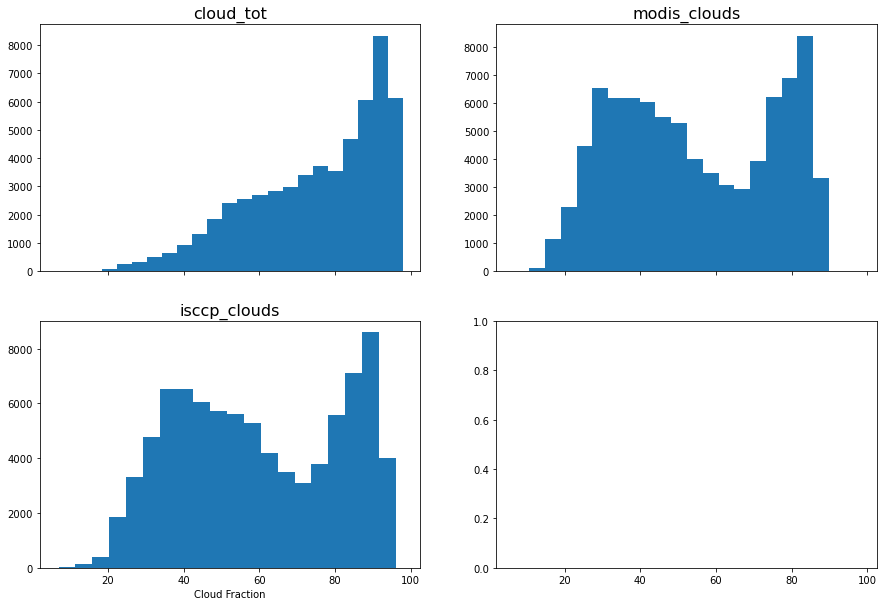

In [53]:
fig, ax = plt.subplots(2,2, figsize = (15,10), sharex = True)

ax = ax.flatten()

# Make the first histogram
ax[0].hist((climatologies.cloud_tot*100).to_numpy().flatten(), bins = 20)
ax[0].set_title('cloud_tot', fontsize = 16);

ax[1].hist(climatologies.modis_clouds.to_numpy().flatten(), bins = 20)
ax[1].set_title('modis_clouds', fontsize = 16);

ax[2].hist(climatologies.isccp_clouds.to_numpy().flatten(), bins = 20)
ax[2].set_title('isccp_clouds', fontsize = 16);
ax[2].set_xlabel('Cloud Fraction');

## Time series

How are varibles distributed over time?

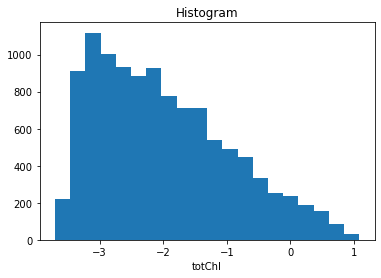

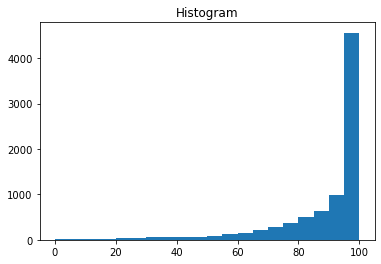

In [68]:
lon = 250
lat = 50
np.log(daily_data.isel(nlon = lon, nlat = lat).totChl).plot.hist(bins = 20);
plt.show()
(daily_data.isel(nlon = lon, nlat = lat).cloudfrac_isccp/daily_data.isel(nlon = lon, nlat = lat).cloudfrac_wgt).plot.hist(bins = 20);
plt.show()

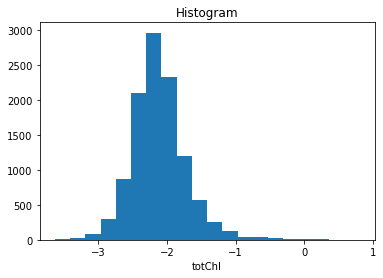

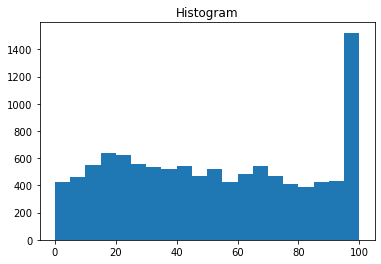

In [69]:
lon = 200
lat = 200
np.log(daily_data.isel(nlon = lon, nlat = lat).totChl).plot.hist(bins = 20);
plt.show()
(daily_data.isel(nlon = lon, nlat = lat).cloudfrac_isccp/daily_data.isel(nlon = lon, nlat = lat).cloudfrac_wgt).plot.hist(bins = 20);
plt.show()

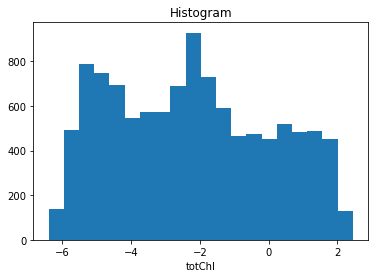

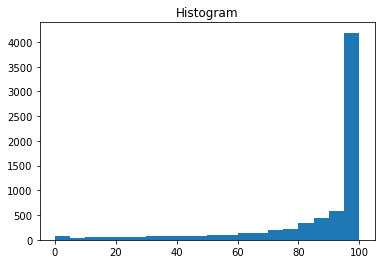

In [70]:
lon = 25
lat = 350
np.log(daily_data.isel(nlon = lon, nlat = lat).totChl).plot.hist(bins = 20);
plt.show()
(daily_data.isel(nlon = lon, nlat = lat).cloudfrac_isccp/daily_data.isel(nlon = lon, nlat = lat).cloudfrac_wgt).plot.hist(bins = 20);
plt.show()

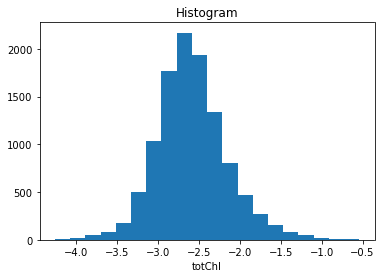

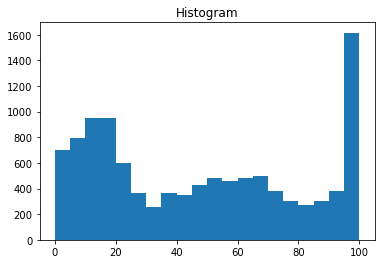

In [72]:
lon = 225
lat = 125
np.log(daily_data.isel(nlon = lon, nlat = lat).totChl).plot.hist(bins = 20);
plt.show()
(daily_data.isel(nlon = lon, nlat = lat).cloudfrac_isccp/daily_data.isel(nlon = lon, nlat = lat).cloudfrac_wgt).plot.hist(bins = 20);
plt.show()

In [73]:
cluster.close()
client.close()